# Analysing the annotations 
This analysis includes:

1. describing the POIs using OSM tags
2. describing the relationship between the OSM tags and the topics for matches
3. finding patterns in unmatched topics
4. comparing the matched OSM records with their surrounding features (not selected - including and excluding the route)

In [1]:
# working with files
import os.path
# sys
import sys
# warning off
import warnings
# IO
import json

# requests
import requests

# dataframe 
import numpy as np
import pandas as pd
import geopandas as gpd


# visualization
import matplotlib.pyplot as plt
import seaborn as sns

# logging
from loguru import logger

# set logger level
logger.remove(0)
logger.add(sys.stderr, level="INFO")

warnings.filterwarnings("ignore")

## 2.1. Walking Map Dataset

Creating a detailed dataframe of all POIs, their description, topic and sub-topic and their point-based representation.

In [2]:
# dataset:

# 0. Geodataframe of all POIs
with open('dataset/walkingmaps.json', 'r', encoding='utf-8') as fp:
    dataset = json.load(fp)

data_structure = {
    'record_id': [], 'record_title':[], 'record_description':[],
    'poi_title':[], 'poi_summary':[], 'latitude': [], 'longitude': []}

for record_id, record in enumerate(dataset):
    if 'pois' in record.keys() and len(record['pois']) > 0:
        for poi in record['pois']:
            data_structure['record_id'].append(record_id)
            data_structure['record_title'].append(record['title'])
            data_structure['record_description'].append(record['description'])
            data_structure['poi_title'].append(poi['title'])
            data_structure['poi_summary'].append(poi['summary'])
            data_structure['latitude'].append(poi['lat'])
            data_structure['longitude'].append(poi['lng'])

df = pd.DataFrame(data_structure)
gdf = gpd.GeoDataFrame(df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326")

print(gdf.head())

# 1. POI - topic
poi_classified = pd.read_csv('outputs/dataframes/refined-topic-poi-description-classified.csv')
poi_classified.head()

   record_id                                       record_title  \
0          1  Fairhaven to Aireys Inlet Walk created by tedm...   
1          1  Fairhaven to Aireys Inlet Walk created by tedm...   
2          1  Fairhaven to Aireys Inlet Walk created by tedm...   
3          1  Fairhaven to Aireys Inlet Walk created by tedm...   
4          1  Fairhaven to Aireys Inlet Walk created by tedm...   

                                  record_description  \
0  Apart from the points of interested listed, he...   
1  Apart from the points of interested listed, he...   
2  Apart from the points of interested listed, he...   
3  Apart from the points of interested listed, he...   
4  Apart from the points of interested listed, he...   

                         poi_title  \
0  Fairhaven Surf Life Saving Club   
1                       Beach walk   
2                       Rock pools   
3                       Sand dunes   
4                  Painkalac Creek   

                               

,Unnamed: 0,level_0,index,topic,document,is_found,class,Count,Name,Representation,Representative_Docs,Class ID,Class,Subclass
0,0,0,0,4,Surf Life Saving Club: is a well known surf be...,False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
1,1,1,1,4,"Beach walk: From Sprout Creek, , , to the bott...",False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
2,2,3,3,4,Sand dunes: The beautiful rolling sand dune sh...,False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
3,3,96,96,4,"Surf' up: A good spot to watch the surf, have ...",False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
4,4,99,99,4,"Heading down to the beach: Follow the track, w...",False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks


In [3]:
gdf.reset_index()
detailed_df = pd.merge(gdf.reset_index(), poi_classified, left_on='index', right_on='index', how='inner')
detailed_df.head()

,index,record_id,record_title,record_description,poi_title,poi_summary,latitude,longitude,geometry,Unnamed: 0,...,document,is_found,class,Count,Name,Representation,Representative_Docs,Class ID,Class,Subclass
0,0,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Fairhaven Surf Life Saving Club,Fairhaven is a well known surf beach. The beac...,-38.468759,144.084459,POINT (144.08446 -38.46876),0,...,Surf Life Saving Club: is a well known surf be...,False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
1,1,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Beach walk,"From Sprout Creek, Eastern View, Moggs Creek, ...",-38.468542,144.089693,POINT (144.08969 -38.46854),1,...,"Beach walk: From Sprout Creek, , , to the bott...",False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
2,2,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Rock pools,See what sort of shells and stones you can col...,-38.468459,144.092420,POINT (144.09242 -38.46846),154,...,Rock pools: See what sort of shell and stone y...,False,NaN,11,66_pools_rock_luna_rockpool,"['pools', 'rock', 'luna', 'rockpool', 'bristle...",['Expansive view and little rock pools.: The o...,4,unknown,unknown
3,3,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Sand dunes,The beautiful rolling sand dunes shape the bea...,-38.468418,144.095318,POINT (144.09532 -38.46842),2,...,Sand dunes: The beautiful rolling sand dune sh...,False,NaN,129,4_beach_bay_tide_sand,"['beach', 'bay', 'tide', 'sand', 'coast', 'pat...",['Broad Tidal Flats: Bay is sow on the western...,0,nature,natural landmarks
4,4,1,Fairhaven to Aireys Inlet Walk created by tedm...,"Apart from the points of interested listed, he...",Painkalac Creek,The creek separates Aireys Inlet from Fairhave...,-38.468390,144.097312,POINT (144.09731 -38.46839),176,...,Painkalac Creek: The creek sete from and form ...,False,NaN,31,25_creek_leary_roderick_flooding,"['creek', 'leary', 'roderick', 'flooding', 'to...",['Painkalac Creek: The creek sete from and for...,0,nature,natural landmarks


## 2.2 Annotations

Loading and parsing the annotations for each point of interest

In [4]:
# reading annotation files
with open('dataset/annotations.json') as fp:
    raw_annotations = json.load(fp)


annotations = {}
for annotation_record in raw_annotations:
    page = None
    annotation = []
    for info in annotation_record:
        if 'page' in info.keys():
            page = str(info['page'])
        elif 'type' in info.keys() and 'osm_id' in info.keys():
            annotation.append(f"{info['type']}:{info['osm_id']}")
        else:
            logger.error(f'structural issues: {info}')

    if page is not None:
        annotations[page] = annotation

logger.info(f'total annotations: {len(annotations)}')

2024-08-11 15:44:03.100 | INFO     | __main__:<module>:21 - total annotations: 4386


In [5]:
annotations

{'0': ['way:1089591567'],
 '1': ['way:1007494584'],
 '2': [],
 '3': [],
 '4': ['way:30501938', 'way:30501933'],
 '5': ['relation:9212157'],
 '6': ['way:69366108', 'way:69366081'],
 '7': ['node:4583492091',
  'node:11158854688',
  'node:11158854687',
  'node:11158854665'],
 '8': ['node:3621405496'],
 '9': [],
 '10': ['node:831201041'],
 '11': [],
 '12': ['way:26564416'],
 '13': ['way:49961266'],
 '14': ['way:26564392', 'node:6758200723'],
 '15': ['node:5371634608'],
 '16': ['node:7228362154', 'way:32710391'],
 '17': ['way:435967756'],
 '18': ['way:436339688',
  'way:436339689',
  'way:436339690',
  'way:1215583957',
  'way:436339691',
  'way:436339692',
  'way:1215583958',
  'way:436339693',
  'way:1215583959',
  'way:436339694',
  'way:436339695',
  'way:1215583956',
  'way:436339696',
  'way:436339697',
  'way:1215583960',
  'way:436339698'],
 '19': [],
 '21': ['node:368393200'],
 '22': ['way:4817074'],
 '23': ['relation:6623509', 'way:4817059', 'node:6810298878'],
 '24': ['relation:6

In [6]:
# download all information from OSM for these matched POIs
api_endpoint = 'https://www.openstreetmap.org/api/0.6/{0}/{1}.json'
headers = {"Content-Type": "application/json; charset=utf-8"}

def get_info(info):
    if info.lower() == 'flag':
        logger.warning('still a flagged record')
        return {}
    otype = info.lower().split(':')[0]
    oid = info.lower().split(':')[1]
    if otype not in ['node', 'way', 'relation']:
        logger.warning('wrong type - {}'.format(otype))
    resp = requests.get(api_endpoint.format(otype, oid), headers=headers)
    return resp.json()

get_info('way:26564416')  # testing

{'version': '0.6',
 'generator': 'CGImap 0.9.3 (4148026 spike-08.openstreetmap.org)',
 'copyright': 'OpenStreetMap and contributors',
 'attribution': 'http://www.openstreetmap.org/copyright',
 'license': 'http://opendatacommons.org/licenses/odbl/1-0/',
 'elements': [{'type': 'way',
   'id': 26564416,
   'timestamp': '2022-11-08T23:44:08Z',
   'version': 13,
   'changeset': 128661596,
   'user': 'MapAbility',
   'uid': 13782447,
   'nodes': [291210982,
    291210974,
    291210988,
    291210981,
    291210998,
    5651652284,
    5651652286,
    5651652285,
    291210982],
   'tags': {'brand': 'YMCA',
    'brand:wikidata': 'Q157169',
    'building': 'yes',
    'heritage': 'yes',
    'leisure': 'sports_centre',
    'name': 'Melbourne City Baths',
    'operator': 'ymca',
    'sport': 'swimming',
    'wikidata': 'Q2786840',
    'wikipedia': 'en:City Baths, Melbourne'}}]}

In [7]:
# Error log for later checkup:
# 2/4386 [00:03<1:56:13,  1.59s/it]2024-08-03 10:03:47.158 | ERROR    | __main__:<module>:12 - 4:way:30501938 error
# 103/4386 [02:56<2:25:38,  2.04s/it]2024-08-03 10:06:40.457 | ERROR    | __main__:<module>:12 - 104:node:flag error
# 104/4386 [02:57<2:05:28,  1.76s/it]2024-08-03 10:06:41.566 | ERROR    | __main__:<module>:12 - 105:node:flag error
# 123/4386 [03:40<2:34:06,  2.17s/it]2024-08-03 10:07:24.255 | ERROR    | __main__:<module>:12 - 129:way:1008233190 error
# 129/4386 [03:41<1:21:47,  1.15s/it]2024-08-03 10:07:25.332 | ERROR    | __main__:<module>:12 - 130:way:1008233190 error
# 130/4386 [03:42<1:21:11,  1.14s/it]2024-08-03 10:07:26.427 | ERROR    | __main__:<module>:12 - 131:way:1008233190 error
# 133/4386 [03:46<1:30:56,  1.28s/it]2024-08-03 10:07:30.706 | ERROR    | __main__:<module>:12 - 136:node:flag error
# 136/4386 [03:47<1:01:56,  1.14it/s]2024-08-03 10:07:31.804 | ERROR    | __main__:<module>:12 - 137:node:flag error
# 205/4386 [05:18<2:05:45,  1.80s/it]2024-08-03 10:09:02.044 | ERROR    | __main__:<module>:12 - 207:node:flag error
# 231/4386 [05:39<1:01:43,  1.12it/s]2024-08-03 10:09:23.175 | ERROR    | __main__:<module>:12 - 234:node:flag error
# 270/4386 [06:33<1:39:43,  1.45s/it]2024-08-03 10:10:17.014 | ERROR    | __main__:<module>:12 - 271:node:flag error
# 297/4386 [07:22<1:50:19,  1.62s/it]2024-08-03 10:11:06.058 | ERROR    | __main__:<module>:12 - 308:node:flag error
# 457/4386 [10:10<1:13:11,  1.12s/it]2024-08-03 10:13:54.346 | ERROR    | __main__:<module>:12 - 459:node:flag error
# 459/4386 [10:11<1:01:12,  1.07it/s]2024-08-03 10:13:55.578 | ERROR    | __main__:<module>:12 - 460:node:flag error
# 661/4386 [13:33<1:21:48,  1.32s/it]2024-08-03 10:17:17.132 | ERROR    | __main__:<module>:12 - 662:node:8850035047 error
# 712/4386 [14:45<1:57:02,  1.91s/it]2024-08-03 10:18:29.385 | ERROR    | __main__:<module>:12 - 713:node:flag error
# 729/4386 [15:06<1:01:31,  1.01s/it]2024-08-03 10:18:50.404 | ERROR    | __main__:<module>:12 - 731:way:1009404233 error
# 966/4386 [20:11<1:03:43,  1.12s/it]2024-08-03 10:23:57.022 | ERROR    | __main__:<module>:12 - 970:node:316598549 error
# 1208/4386 [25:12<15:44,  3.37it/s]2024-08-03 10:28:56.058 | ERROR    | __main__:<module>:12 - 1209:way:277584589 error
# 1648/4386 [33:41<2:05:48,  2.76s/it]2024-08-03 10:37:25.365 | ERROR    | __main__:<module>:12 - 1649:node:2397398815 error
# 1653/4386 [33:53<1:42:39,  2.25s/it]2024-08-03 10:37:37.538 | ERROR    | __main__:<module>:12 - 1654:node:flag error
# 1778/4386 [36:03<1:01:09,  1.41s/it]2024-08-03 10:39:47.312 | ERROR    | __main__:<module>:12 - 1779:way:490502525 error
# 2024/4386 [40:52<41:47,  1.06s/it]2024-08-03 10:44:36.498 | ERROR    | __main__:<module>:12 - 2028:way:1009406415 error
# 2030/4386 [40:54<28:58,  1.36it/s]2024-08-03 10:44:38.648 | ERROR    | __main__:<module>:12 - 2032:way:1009406415 error
# 2402/4386 [47:27<53:14,  1.61s/it]2024-08-03 10:51:11.918 | ERROR    | __main__:<module>:12 - 2403:node:2397398815 error
# 2472/4386 [48:56<26:37,  1.20it/s]2024-08-03 10:52:40.128 | ERROR    | __main__:<module>:12 - 2473:way: 12283703 error
# 3052/4386 [1:01:32<33:49,  1.52s/it]2024-08-03 11:05:16.546 | ERROR    | __main__:<module>:12 - 3054:node:4469652313 error
# 3270/4386 [1:05:39<12:45,  1.46it/s]2024-08-03 11:09:23.517 | ERROR    | __main__:<module>:12 - 3272:way:1007170487 error
# 3484/4386 [1:09:48<19:36,  1.30s/it]2024-08-03 11:13:35.092 | ERROR    | __main__:<module>:12 - 3485:way:799508737 error
# 2024-08-03 11:13:36.200 | ERROR    | __main__:<module>:12 - 3485:way:934955492 error
# 3582/4386 [1:11:43<22:12,  1.66s/it]2024-08-03 11:15:27.897 | ERROR    | __main__:<module>:12 - 3588:node:4682651695 error
# 3704/4386 [1:13:37<15:16,  1.34s/it]2024-08-03 11:17:21.901 | ERROR    | __main__:<module>:12 - 3710:node:3838183016 error
# 4386/4386 [1:23:20<00:00,  1.14s/it]

In [8]:
from tqdm import tqdm
import time 

if os.path.isfile('outputs/annotations_details_osm_info.json'):
    with open('outputs/annotations_details_osm_info.json') as fp:
        osm_detailed_information = json.load(fp)

    logger.info('annotation details are loaded from cache')
else:
    logger.info('annotation cache cannot be found, will fetch the results from OSM')
    # save all information about the matched records
    osm_detailed_information = {}
    for poi_id, matches in tqdm(annotations.items()):
        osm_detailed_information[poi_id] = {}
        for match in matches:
            try:
                osm_detailed_information[poi_id][match] = get_info(match)
                time.sleep(0.5)  # for polite crawling
            except Exception as e:
                logger.error(f'{poi_id}:{match} error', exc_info=True)
    with open('outputs/annotations_details_osm_info.json', 'w', encoding='utf-8') as fp:
        json.dump(osm_detailed_information, fp)
    logger.info('annotation details are saved and will be loaded the later runs...')

2024-08-11 15:44:04.560 | INFO     | __main__:<module>:8 - annotation details are loaded from cache


In [9]:
poi_matched_and_founds = [p for p,v in osm_detailed_information.items() if len(v) > 0]
poi_not_matched = [p for p in osm_detailed_information.keys() if p not in poi_matched_and_founds]
osm_matched_and_founds = [len(v) for v in osm_detailed_information.values()]

logger.info(f'\nannotation details are available for: {sum(osm_matched_and_founds)} osm entities out of {len(poi_matched_and_founds)} matched pois\nNote that the relationship is not one to one')

2024-08-11 15:44:05.817 | INFO     | __main__:<module>:5 - 
annotation details are available for: 3255 osm entities out of 2379 matched pois
Note that the relationship is not one to one


In [10]:
osm_detailed_information['1']

{'way:1007494584': {'version': '0.6',
  'generator': 'CGImap 0.9.3 (987906 spike-08.openstreetmap.org)',
  'copyright': 'OpenStreetMap and contributors',
  'attribution': 'http://www.openstreetmap.org/copyright',
  'license': 'http://opendatacommons.org/licenses/odbl/1-0/',
  'elements': [{'type': 'way',
    'id': 1007494584,
    'timestamp': '2024-06-29T04:38:50Z',
    'version': 3,
    'changeset': 153317242,
    'user': 'Fizzie41',
    'uid': 461130,
    'nodes': [9294714213,
     9294714214,
     9294714215,
     9294714216,
     9294780017,
     9294780018,
     9294780019,
     9294780020,
     9294780021,
     9294780022,
     9294780023,
     9294780024,
     9294780025,
     9294780026,
     9294780027,
     9294780028,
     9294780029,
     9294780030,
     9294780031,
     9294780032,
     9294780033,
     9294780034,
     9294780035,
     9294780036,
     9294780037,
     9294780038,
     9294780039,
     9294780040,
     9294780041,
     9294780042,
     9294780043,
     9

## 2.3 Nearby OSM features
This will load already stored nearby features - see the `2. annotation analysis.ipynb` for more details.

In [11]:
# load nearby features:
def get_osm_poi_nearby(key):
    logger.debug('key: {}'.format(key))
    dist_threshold = 200  # for normal cases
    if os.path.isfile('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, dist_threshold)):
        features =  gpd.read_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, dist_threshold))
    else:
        features =  gpd.read_file('dataset/osm-poi-{0}-dist-{1}-features.geojson'.format(key, 1000))
    features = features.to_crs('EPSG:32755')
    return features

def get_osm_pois_nearby(poi_keys):
    osm_pois = {}
    for key in tqdm(poi_keys):
        features = get_osm_poi_nearby(key)
        osm_pois[key] = features
    return osm_pois

matched_nearby_features = get_osm_pois_nearby(poi_matched_and_founds[:5])
unmatched_nearby_features = get_osm_pois_nearby(poi_not_matched[:5])

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:20<00:00,  4.18s/it]


## 3.1 Topics/SubClass/Class Relation to OSM KeyValues

To study how POIs belonging to each cateogries is described in OSM

Can we find from OSM key values which kind of POI we are dealing with? - Context: we already know about the quality issue of OSM attributes and if the POIs are well document (community care about them), we can expect a good coverage of attribute information!)

In [12]:
detailed_df.columns

Index(['index', 'record_id', 'record_title', 'record_description', 'poi_title',
       'poi_summary', 'latitude', 'longitude', 'geometry', 'Unnamed: 0',
       'level_0', 'topic', 'document', 'is_found', 'class', 'Count', 'Name',
       'Representation', 'Representative_Docs', 'Class ID', 'Class',
       'Subclass'],
      dtype='object')

In [13]:
filtered_df = detailed_df[['index', 'record_id', 'topic', 'Class ID', 'Class', 'Subclass']]
filtered_df.head()
# 4 concepts are captured about POIs in this dataframe
# Points of interest: index column
    # 1. Leisure walk: record_id column
    # 2. detailed topic: topic column
    # 3. Sub-class (aggregation of topics): Subclass
    # 4. Class (aggregation of subclasses): Class

,index,record_id,topic,Class ID,Class,Subclass
0,0,1,4,0,nature,natural landmarks
1,1,1,4,0,nature,natural landmarks
2,2,1,66,4,unknown,unknown
3,3,1,4,0,nature,natural landmarks
4,4,1,25,0,nature,natural landmarks


In [14]:
from string import digits

def get_all_key_values(poi_id):
    if poi_id not in osm_detailed_information.keys():
        logger.info(f'missing key in OSM details: {poi_id}')
        return []
    all_info = osm_detailed_information[poi_id]
    tags = []
    for oid, values in all_info.items():
        if 'elements' in values.keys():
            tmp_tags = [[k+' '+v for k,v in elem['tags'].items() if 'name' not in k] for elem in values['elements'] if 'tags' in elem]
            tmp_tags = [t for tag in tmp_tags for t in tag]
            tags.extend(tmp_tags)
    return remove_digits(' '.join(tags))

def remove_digits(s):
    remove_digits = str.maketrans('', '', digits)
    res = s.translate(remove_digits)
    return res


get_all_key_values('5')
# osm_detailed_information['1']['way:1007494584']['elements']

'boundary protected_area iucn_level III leisure nature_reserve operator Victorian Department of Environment, Land, Water and Planning protect_class  protection_title Marine Sanctuary ref:capad:pa_id  ref:vicmap:prims_id  source CAPAD start_date -- type boundary'

In [15]:
filtered_df['tags'] = filtered_df.apply(lambda row: get_all_key_values(str(row['index'])), axis=1)
filtered_df.head()

2024-08-11 15:44:55.299 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 20
2024-08-11 15:44:55.332 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3551
2024-08-11 15:44:55.334 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3552
2024-08-11 15:44:55.335 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3553
2024-08-11 15:44:55.335 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3554
2024-08-11 15:44:55.336 | INFO     | __main__:get_all_key_values:5 - missing key in OSM details: 3555


,index,record_id,topic,Class ID,Class,Subclass,tags
0,0,1,4,0,nature,natural landmarks,addr:housenumber addr:postcode addr:street G...
1,1,1,4,0,nature,natural landmarks,natural beach surface sand
2,2,1,66,4,unknown,unknown,
3,3,1,4,0,nature,natural landmarks,
4,4,1,25,0,nature,natural landmarks,waterway stream


In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

labelled_filtered_df = filtered_df[filtered_df['Class'] != 'unknown']

labelled_filtered_df['class_id'] = labelled_filtered_df['Class'].astype('category').cat.codes
target = labelled_filtered_df['class_id']
data = labelled_filtered_df['tags'].astype(str)

data_train, data_test, target_train, target_test = train_test_split(data, target, test_size=0.2, random_state=432)

vectorizer = TfidfVectorizer(sublinear_tf=True, max_df=0.5, min_df=5, stop_words="english")
X_train = vectorizer.fit_transform(data_train)
X_test =  vectorizer.transform(data_test)

In [52]:
feature_names = vectorizer.get_feature_names_out()

In [53]:
feature_names

array(['abandoned', 'access', 'act', 'addr', 'address', 'amenity',
       'amphi', 'arch', 'architect', 'area', 'arts_centre', 'artwork',
       'artwork_type', 'asphalt', 'attraction', 'au', 'australia',
       'australian_football', 'avenue', 'backrest', 'bakery', 'ballarat',
       'bar', 'barrier', 'bay', 'bbq', 'beach', 'bench', 'bendigo',
       'bicycle', 'bin', 'bing', 'bmx', 'board', 'boardwalk', 'boat',
       'botanic', 'boulevard', 'boundary', 'bowls', 'branch', 'brand',
       'bridge', 'building', 'bus', 'bus_stop', 'cafe', 'camp', 'capad',
       'carlton', 'category', 'cathedral', 'catholic', 'centre',
       'check_date', 'christian', 'church', 'city', 'closed', 'club',
       'colour', 'com', 'compacted', 'concrete', 'construction',
       'contact', 'council', 'country', 'covered', 'created_by',
       'cricket', 'cuisine', 'culvert', 'cureton', 'cycleway',
       'denomination', 'department', 'description', 'designated',
       'designation', 'dirt', 'drinking_water

In [54]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate

clf = RidgeClassifier(tol=1e-2, solver="sparse_cg")
cv_results = cross_validate(clf, X_train, target_train, cv=10, return_estimator=True)

sorted(cv_results.keys())

['estimator', 'fit_time', 'score_time', 'test_score']

In [55]:
clf = cv_results['estimator'][cv_results['test_score'].argmax()]
cv_results['test_score']

array([0.61075949, 0.68037975, 0.66349206, 0.62857143, 0.68888889,
       0.62857143, 0.62222222, 0.62539683, 0.66984127, 0.63174603])

In [56]:
pred = clf.predict(X_test)

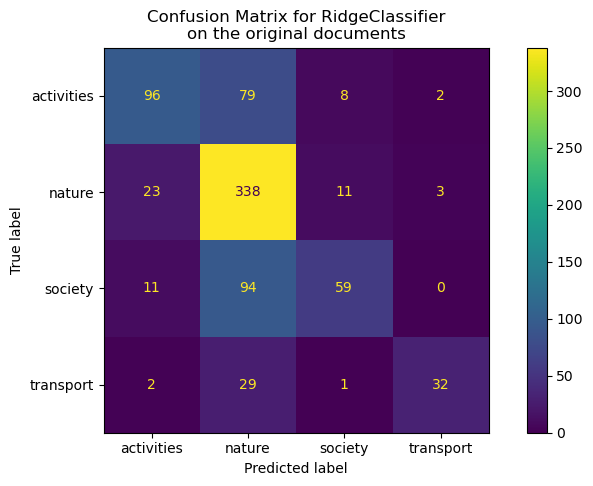

In [57]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay
target_names = (['activities', 'nature', 'society', 'transport'])
fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(target_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [58]:
from sklearn.metrics import classification_report
classification_report(target_test, pred, output_dict=True)  

{'0': {'precision': 0.7272727272727273,
  'recall': 0.518918918918919,
  'f1-score': 0.6056782334384858,
  'support': 185},
 '1': {'precision': 0.6259259259259259,
  'recall': 0.9013333333333333,
  'f1-score': 0.7387978142076501,
  'support': 375},
 '2': {'precision': 0.7468354430379747,
  'recall': 0.3597560975609756,
  'f1-score': 0.48559670781892994,
  'support': 164},
 '3': {'precision': 0.8648648648648649,
  'recall': 0.5,
  'f1-score': 0.6336633663366337,
  'support': 64},
 'accuracy': 0.666243654822335,
 'macro avg': {'precision': 0.7412247402753732,
  'recall': 0.5700020874533069,
  'f1-score': 0.6159340304504249,
  'support': 788},
 'weighted avg': {'precision': 0.6942893918493097,
  'recall': 0.666243654822335,
  'f1-score': 0.6463096053830428,
  'support': 788}}

In [67]:
tmp_dict = labelled_filtered_df[['Class', 'class_id']].groupby(by=['class_id', 'Class']).count().reset_index().to_dict(orient='records')
class_labels = {r['class_id']:r['Class'] for r in tmp_dict}

[{'class_id': 0, 'Class': 'activities'},
 {'class_id': 1, 'Class': 'nature'},
 {'class_id': 2, 'Class': 'society'},
 {'class_id': 3, 'Class': 'transport'}]

In [45]:
import shap
explainer = shap.Explainer(clf, X_train, feature_names=feature_names, )
explanation = explainer(X_train)

In [46]:
explanation.shape

(3152, 361, 4)

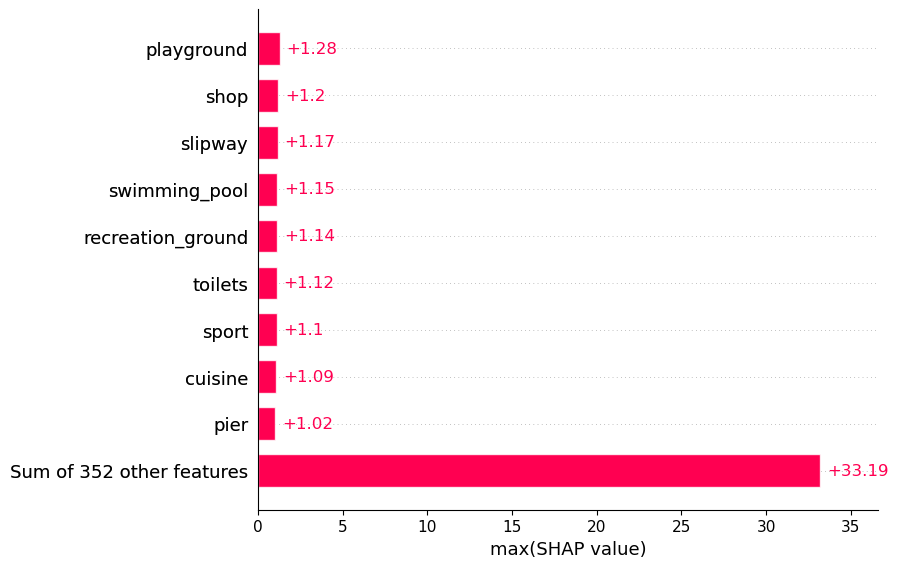

In [74]:
shap.plots.bar(explanation[:, :, 0].max(0))

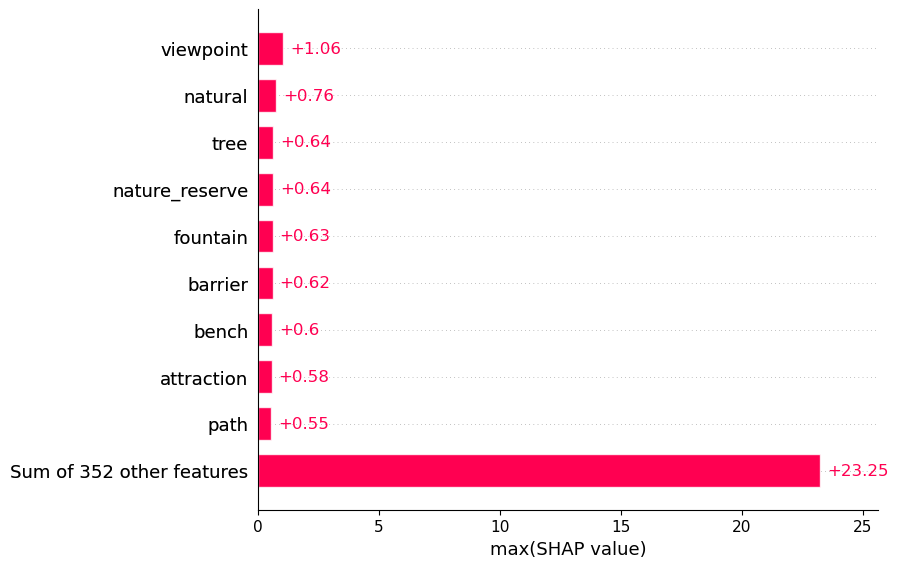

In [75]:
shap.plots.bar(explanation[:, :, 1].max(0))

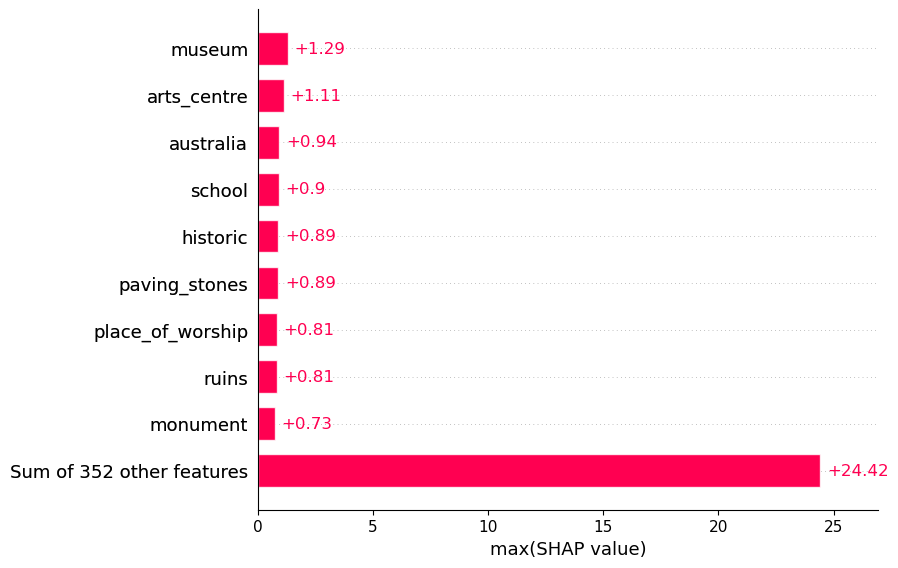

In [76]:
shap.plots.bar(explanation[:, :, 2].max(0))

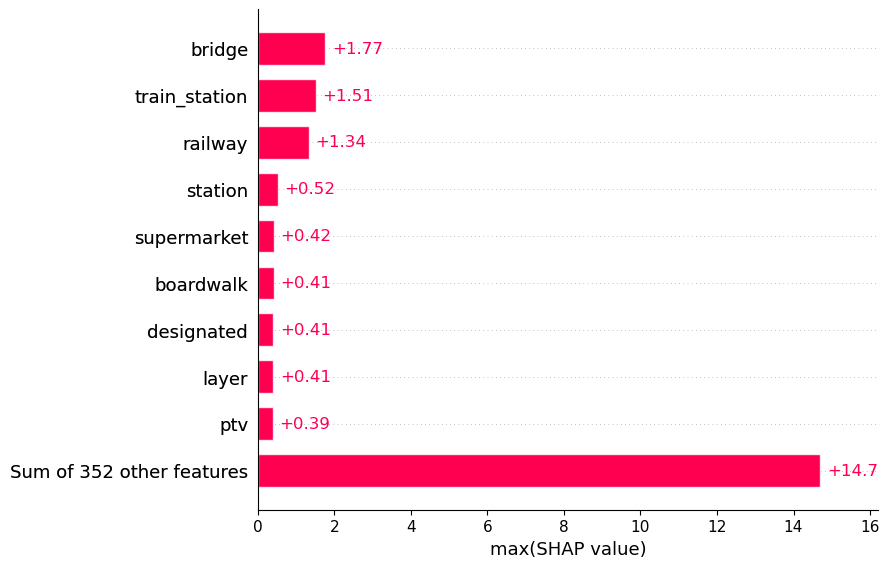

In [80]:
shap.plots.bar(explanation[:, :, 3].max(0))

In [81]:
pred

array([2, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 2, 1, 1, 2, 0, 1, 1, 1,
       1, 0, 1, 0, 0, 1, 1, 1, 2, 1, 0, 1, 1, 0, 0, 3, 1, 2, 1, 0, 1, 1,
       1, 1, 0, 1, 3, 1, 1, 1, 0, 0, 1, 2, 0, 1, 2, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 0, 2, 1, 1, 1, 0, 0, 2, 1, 1, 0, 1, 2, 1, 1, 1,
       0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 2, 1,
       1, 2, 1, 3, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 3, 1, 1, 3, 1, 1, 1,
       0, 0, 0, 3, 1, 1, 1, 1, 1, 1, 1, 1, 2, 1, 3, 1, 1, 1, 3, 2, 1, 1,
       1, 0, 0, 0, 3, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0,
       1, 1, 0, 0, 2, 0, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 0, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 2, 1, 1, 1, 3, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 2, 2, 1, 0, 1, 0, 1, 2, 1, 1, 1, 1, 0, 1, 2, 1,
       0, 3, 2, 1, 1, 2, 1, 1, 1, 2, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1,
       0, 1, 1, 1, 1, 1, 3, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 2, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1,

In [82]:
list(target_test)

[0,
 1,
 1,
 2,
 2,
 2,
 0,
 1,
 0,
 0,
 3,
 1,
 0,
 1,
 2,
 0,
 2,
 2,
 2,
 2,
 0,
 1,
 1,
 0,
 1,
 0,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 2,
 1,
 0,
 2,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 3,
 1,
 1,
 1,
 0,
 0,
 1,
 0,
 1,
 1,
 2,
 1,
 2,
 2,
 1,
 2,
 2,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 0,
 1,
 1,
 2,
 0,
 2,
 1,
 1,
 0,
 1,
 2,
 1,
 3,
 2,
 0,
 3,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 1,
 0,
 1,
 0,
 0,
 0,
 1,
 2,
 1,
 1,
 1,
 2,
 1,
 2,
 1,
 2,
 3,
 1,
 2,
 1,
 1,
 0,
 1,
 1,
 3,
 1,
 2,
 1,
 3,
 1,
 1,
 3,
 1,
 3,
 1,
 0,
 0,
 0,
 3,
 2,
 1,
 3,
 1,
 1,
 1,
 0,
 1,
 2,
 1,
 3,
 2,
 0,
 1,
 3,
 2,
 0,
 1,
 1,
 1,
 2,
 1,
 0,
 1,
 1,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 0,
 1,
 1,
 3,
 1,
 1,
 1,
 0,
 0,
 2,
 0,
 0,
 2,
 0,
 1,
 3,
 1,
 0,
 1,
 1,
 1,
 1,
 1,
 2,
 1,
 1,
 1,
 3,
 0,
 2,
 1,
 0,
 1,
 0,
 2,
 3,
 0,
 1,
 3,
 3,
 1,
 0,
 0,
 2,
 2,
 1,
 1,
 2,
 3,
 0,
 1,
 0,
 1,
 1,
 0,
 2,
 1,
 1,
 2,
 2,
 1,
 0,
 0,
 0,
 0,
 2,
 2,
 1,
 1,
 1,
 1,
 1,
 2,
 0,
 0,
 3,
 1,
 2,
 3,
 2,
 1,
 1,


In [83]:
prediction_errors = [a != pred[idx] for idx, a in enumerate(list(target_test))]
prediction_errors

[True,
 False,
 False,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 True,
 True,
 False,
 True,
 True,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 False,
 False,
 False,
 False,
 True,
 False,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 True,
 True,
 True,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 True,
 False,
 True,
 False,
 False,
 False,
 False,
 False,
 False,
 

In [84]:
data_test[prediction_errors]

887     amenity university website http://www.rmit.edu...
2710                                                     
1435        highway residential maxspeed  surface asphalt
3904                                                     
1122                                                     
                              ...                        
254                                                      
957                                                      
1253    bridge cantilever destination:lanes Lorimer St...
4360                                                     
258     addr:housenumber  addr:postcode  addr:state VI...
Name: tags, Length: 263, dtype: object

In [85]:
error_preds = [p for idx, p in enumerate(pred) if prediction_errors[idx]]
error_actual = [p for idx, p in enumerate(list(target_test)) if prediction_errors[idx]]
error_df = pd.DataFrame({'index': data_test[prediction_errors].index, 'osm_info': list(data_test[prediction_errors]), 'pred': error_preds, 'actual': error_actual})
error_df

,index,osm_info,pred,actual
0,887,amenity university website http://www.rmit.edu...,2,0
1,2710,,1,2
2,1435,highway residential maxspeed surface asphalt,1,2
3,3904,,1,0
4,1122,,1,0
...,...,...,...,...
258,254,,1,2
259,957,,1,2
260,1253,bridge cantilever destination:lanes Lorimer St...,3,1
261,4360,,1,3


In [86]:
error_df = pd.merge(error_df, detailed_df[['index', 'record_id', 'topic', 'Subclass']], how="left", on=["index", "index"])
error_df

,index,osm_info,pred,actual,record_id,topic,Subclass
0,887,amenity university website http://www.rmit.edu...,2,0,64,7,picnic area
1,2710,,1,2,229,32,"art, history and culture"
2,1435,highway residential maxspeed surface asphalt,1,2,113,50,human made landmarks
3,3904,,1,0,344,44,sport complexes
4,1122,,1,0,85,35,sport complexes
...,...,...,...,...,...,...,...
258,254,,1,2,17,17,"art, history and culture"
259,957,,1,2,69,17,"art, history and culture"
260,1253,bridge cantilever destination:lanes Lorimer St...,3,1,97,1,flora and funa
261,4360,,1,3,384,20,trail-path-and-canal


In [87]:
error_df['lack_of_context'] = error_df.apply(lambda row: row['osm_info'].strip() in ('', '[]'), axis=1)
error_df

,index,osm_info,pred,actual,record_id,topic,Subclass,lack_of_context
0,887,amenity university website http://www.rmit.edu...,2,0,64,7,picnic area,False
1,2710,,1,2,229,32,"art, history and culture",True
2,1435,highway residential maxspeed surface asphalt,1,2,113,50,human made landmarks,False
3,3904,,1,0,344,44,sport complexes,True
4,1122,,1,0,85,35,sport complexes,True
...,...,...,...,...,...,...,...,...
258,254,,1,2,17,17,"art, history and culture",True
259,957,,1,2,69,17,"art, history and culture",True
260,1253,bridge cantilever destination:lanes Lorimer St...,3,1,97,1,flora and funa,False
261,4360,,1,3,384,20,trail-path-and-canal,True


In [88]:
error_df.groupby('lack_of_context').count()

,index,osm_info,pred,actual,record_id,topic,Subclass
lack_of_context,,,,,,,
False,110,110,110,110,110,110,110
True,153,153,153,153,153,153,153


In [89]:
error_df.to_csv('outputs/error_poi_description.csv')

In [90]:
(788-263)/788*100

66.6243654822335

In [91]:
(788-263+153)/(788)*100  # if there is context - it can be derived from the context!

86.04060913705584

**conclusion**: these feautres are relatively standardize due to their known imporatnace otherwise much lower results expected from the OSM attribute information

In [92]:
# key classification
# use presence of keys to predict class

In [93]:
def get_all_key_values_tags(poi_id):
    if poi_id not in osm_detailed_information.keys():
        logger.info(f'missing key in OSM details: {poi_id}')
        return []
    all_info = osm_detailed_information[poi_id]
    tags = []
    for oid, values in all_info.items():
        if 'elements' in values.keys():
            tmp_tags = [[k for k,v in elem['tags'].items() if 'name' not in k] for elem in values['elements'] if 'tags' in elem]
            tmp_tags = [t for tag in tmp_tags for t in tag]
            tags.extend(tmp_tags)
    return tags

get_all_key_values_tags('5')

['boundary',
 'iucn_level',
 'leisure',
 'operator',
 'protect_class',
 'protection_title',
 'ref:capad:pa_id',
 'ref:vicmap:prims_id',
 'source',
 'start_date',
 'type']

In [94]:
filtered_df = detailed_df[['index', 'record_id', 'topic', 'Class ID', 'Class', 'Subclass']]
filtered_df['tags'] = filtered_df.apply(lambda row: get_all_key_values_tags(str(row['index'])), axis=1)
filtered_df.head()

2024-08-11 16:05:35.721 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 20
2024-08-11 16:05:35.744 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3551
2024-08-11 16:05:35.744 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3552
2024-08-11 16:05:35.745 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3553
2024-08-11 16:05:35.747 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3554
2024-08-11 16:05:35.748 | INFO     | __main__:get_all_key_values_tags:3 - missing key in OSM details: 3555


,index,record_id,topic,Class ID,Class,Subclass,tags
0,0,1,4,0,nature,natural landmarks,"[addr:housenumber, addr:postcode, addr:street,..."
1,1,1,4,0,nature,natural landmarks,"[natural, surface]"
2,2,1,66,4,unknown,unknown,[]
3,3,1,4,0,nature,natural landmarks,[]
4,4,1,25,0,nature,natural landmarks,[waterway]


In [95]:
all_keys = [k for keys in filtered_df['tags'] for k in keys]
logger.info(f'all keys: {len(all_keys)} - unqiue keys: {len(set(all_keys))}')

2024-08-11 16:05:36.785 | INFO     | __main__:<module>:2 - all keys: 12701 - unqiue keys: 472


In [96]:
from collections import Counter

features = [k for k,v in Counter(all_keys).items() if v > 25]

In [97]:
class_dicts = filtered_df[['Class', 'tags']].to_dict(orient='records')
classification_records = []
for class_dict in class_dicts:
    if class_dict['Class'] == 'unknown':
        continue
    classification_record = {'class': class_dict['Class']}
    for feature in features:
        if feature in class_dict['tags']:
           classification_record[feature] = 1
        else:
            classification_record[feature] = 0
    classification_records.append(classification_record)

classfication_df = pd.DataFrame(classification_records)
classfication_df.head()

,class,addr:housenumber,addr:postcode,addr:street,natural,surface,waterway,leisure,operator,source,...,area,horse,cycleway:both,maxspeed,shop,railway,train,water,lanes,crossing
0,nature,1,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,nature,0,0,0,1,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,nature,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,nature,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,activities,0,0,0,0,1,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [98]:
from sklearn.ensemble import GradientBoostingClassifier

y = classfication_df['class']
X = classfication_df.drop('class', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=432)
clf = GradientBoostingClassifier(n_estimators=100, learning_rate=1.0, random_state=432)

cv_results = cross_validate(clf, X_train, y_train, cv=10, return_estimator=True)
clf = cv_results['estimator'][cv_results['test_score'].argmax()]
cv_results['test_score']

pred = clf.predict(X_test)

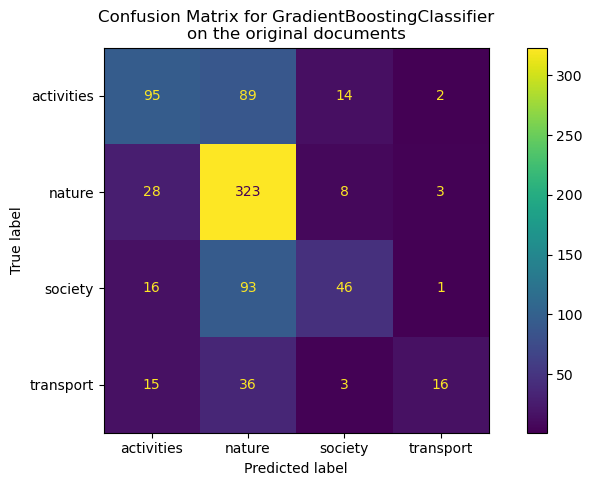

In [99]:
import matplotlib.pyplot as plt

from sklearn.metrics import ConfusionMatrixDisplay

fig, ax = plt.subplots(figsize=(10, 5))
ConfusionMatrixDisplay.from_predictions(y_test, pred, ax=ax)
ax.xaxis.set_ticklabels(target_names)
ax.yaxis.set_ticklabels(target_names)
_ = ax.set_title(
    f"Confusion Matrix for {clf.__class__.__name__}\non the original documents"
)

In [100]:
from sklearn.metrics import classification_report
classification_report(y_test, pred, output_dict=True)  

{'activities': {'precision': 0.6168831168831169,
  'recall': 0.475,
  'f1-score': 0.5367231638418078,
  'support': 200},
 'nature': {'precision': 0.5970425138632163,
  'recall': 0.8922651933701657,
  'f1-score': 0.7153931339977851,
  'support': 362},
 'society': {'precision': 0.647887323943662,
  'recall': 0.2948717948717949,
  'f1-score': 0.4052863436123348,
  'support': 156},
 'transport': {'precision': 0.7272727272727273,
  'recall': 0.22857142857142856,
  'f1-score': 0.34782608695652173,
  'support': 70},
 'accuracy': 0.6091370558375635,
 'macro avg': {'precision': 0.6472714204906806,
  'recall': 0.47267710420334735,
  'f1-score': 0.5013071821021124,
  'support': 788},
 'weighted avg': {'precision': 0.6237125975119415,
  'recall': 0.6091370558375635,
  'f1-score': 0.5760018311751783,
  'support': 788}}

# NOTE - TODO list

1. explain how these model works -> contextualize it with respect to the categories identified!
2. derive basic stats of what keys for what subclass/class
3. start comparing key values of selected vs. not selected features: distance to the path, type and OSM information, pattern in not selected - what tags/values?
5. build a binary classifier (both text and feature engineering) to label important or not for leisure walking - create a frequent tag feature dataset and start building a binary classifier - input feature --> is it selected? - then describe what it achieves and how it performs
6. optional: add a text classifier - DNN to show it can be improved by embeddings?